# Pinecone Cost Estimation

This notebook tends to provide an estimate of the cost associated with using Pinecone's offering. We will ingest a random dataset to get an estimate of the units consumed.

The UI can provide the number of units consumed.

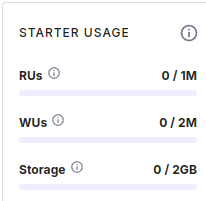

Unfortunately, this widget does not update in realtime. There is a dashboard where different metrics are displayed including storage and RU/WU **per time**.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from pinecone import Pinecone
import os

api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=api_key)

In [4]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

We create an index of 1536 dimensions equal to that of OpenAI's embedding

In [5]:
index_name = "cost-estimate"

import time

if index_name not in pc.list_indexes().names():
    print(f'Creating index \"{index_name}\"...\n')
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=spec
    )
    if index_name in pc.list_indexes().names():
        print(f'Successfully created index \"{index_name}\"!')
else:
    print(f'An index named \"{index_name}\" already exists!')

# wait for index to be ready before connecting
while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

Creating index "cost-estimate"...

Successfully created index "cost-estimate"!


In [6]:
# Instantiate index object with your index_name

index = pc.Index(index_name)

In [24]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Ingest Data

We create a helper function to generate synthetic vectors of different sizes and ingest into our database. 

In [23]:
import uuid
import numpy as np
from tqdm import tqdm

def ingest(namespace, size, BATCHES = 100, BATCH_SIZE = 100, DIMS = 1536):
    print(f'Populating namespace "{namespace}":')

    # Calculate the total number of iterations needed
    total_iterations = size // (BATCH_SIZE * BATCHES)

    # Process data in batches using tqdm for progress indication
    for _ in tqdm(range(total_iterations)):

        # Initialize an empty list to store all batches
        all_batches = []

        # Outer loop to create multiple batches
        for _ in range(BATCHES):

            # Initialize an empty list for a single batch
            single_batch = []

            # Inner loop to create each item in the batch
            for _ in range(BATCH_SIZE):

                # Generate a random vector value using numpy
                random_vector_value = np.random.rand(DIMS)

                # Create a tuple with a unique ID, the random vector value, and some toy metadata
                item = (str(uuid.uuid4()), random_vector_value, {'metadata': 'some toy metadata'})

                # Add the created item to the single batch
                single_batch.append(item)

            # Add the single batch to the list of all batches
            all_batches.append(single_batch)

        # Upsert (update/insert) each batch
        for batch in all_batches:
            index.upsert(vectors=batch, async_req=True, namespace=namespace)
            



We ingest 50k vectors into our database

In [25]:
ingest('50k', 50_000)

Populating namespace "50k":


100%|██████████| 5/5 [02:28<00:00, 29.79s/it]


In [27]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'50k': {'vector_count': 50000}},
 'total_vector_count': 50000}

According to the website, this consumes 700 WUs

$$\text{WUs consumed} = \frac{\text{total records}}{\text{records per batch}} \times \frac{700 \text{ WUs}}{\text{batch}} = \frac{50000}{100} \times 700 = 350K \text{ }WUs$$


$$ Cost = \frac{\$4}{1M \text{ } WUs} *  350K \text{ }WUs = \$1.4 $$

## Read

We create a dummy vector to perform a read operation.

In [28]:
dummy_vectorized_query = [0] * 1536

In [29]:
index.query(vector=dummy_vectorized_query, top_k=10, namespace='50k')['usage']['read_units']

5

This shows that 5 RUs have been consumed.

$$ Cost = \frac{\$16}{1M \text{ } WUs} *  5 \text{ }WUs = \$0.00008 $$


## Storage

The dashboard shows a storage size of 0.316 GB for this dataset.

$$ Cost = \$0.33 \text{GB} / \text{month} *  0.316 \text{GB} = \$0.104 / \text{month} $$
